In [1]:
from sklearn import preprocessing
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as mp
from sentence_transformers import SentenceTransformer
model=SentenceTransformer('sentence-transformers/sentence-t5-base')
a = 'training.xlsx'
dtrain = pd.read_excel(a)
y = 'testing.xlsx'
dtest = pd.read_excel(y)

    #class labelling
dtrain['class'] = dtrain['output'].apply(lambda x: 'Correct' if x == 5 else ('Partially correct' if x>=2 and x<5 else 'Incorrect'))
correct = dtrain[dtrain['class'] == 'Correct']
partial = dtrain[dtrain['class'] == 'Partially correct']
incorrect = dtrain[dtrain['class'] == 'Incorrect']

dtrain.to_excel('training_labelled.xlsx', index=False)

    #removing line breaks and converting to str
def remove(s):
    if isinstance(s, str):
        return ' '.join(s.splitlines())
    else:
        return s
    
dtrain['string_converted_input'] = dtrain['input'].apply(remove)
dtrain['EmbeddingsLM']=dtrain['string_converted_input'].apply(lambda x:model.encode(str(x)))

dtest['string_converted_equation'] = dtest['Equation'].apply(remove)
dtest['EmbeddingsLM']=dtest['string_converted_equation'].apply(lambda x:model.encode(str(x)))

In [3]:
    #stripping spaces in embeddings
dtrain['Embeddings_converted'] = dtrain['EmbeddingsLM'].apply(lambda x: x.tolist())
num_columns = len(dtrain['Embeddings_converted'][0]) 

In [4]:
for i in range(num_columns):
    col_name = "Embedding_"+str(i)
    dtrain[col_name] = dtrain['Embeddings_converted'].apply(lambda x: x[i])

dtrain.to_excel('training_data_updated.xlsx', index=False)

C:\Users\subhi\AppData\Local\Temp\ipykernel_12372\1921526927.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dtrain[col_name] = dtrain['Embeddings_converted'].apply(lambda x: x[i])
C:\Users\subhi\AppData\Local\Temp\ipykernel_12372\1921526927.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dtrain[col_name] = dtrain['Embeddings_converted'].apply(lambda x: x[i])
C:\Users\subhi\AppData\Local\Temp\ipykernel_12372\1921526927.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [5]:
#taking out numeric values to calculate mean etc
numeric_dtrain=dtrain.copy()
numeric_dtrain.drop(columns=['input','string_converted_input'], inplace=True)

def labelenc(x):
    if(x=='Incorrect'):
        return 0
    elif(x=='Partially correct'):
        return 1
    if(x=='Correct'):
        return 2

numeric_dtrain['class_encoded'] = dtrain['class'].apply(labelenc)
numeric_dtrain.drop(columns=['class','EmbeddingsLM','Embeddings_converted'], inplace=True)

columns = numeric_dtrain.columns.tolist()
first_col = columns.pop(0)
columns.insert(-1, first_col)
numeric_dtrain = numeric_dtrain[columns]

numeric_dtrain.to_excel('numeric_data_updated.xlsx', index=False)

In [6]:
'''
A1. Evaluate the intra-class spread and interclass distances between the classes in your dataset. 
If your data deals with multiple classes, you can take any two classes. 

'''
class_0  = numeric_dtrain[numeric_dtrain['class_encoded'] == 0]
class_1  = numeric_dtrain[numeric_dtrain['class_encoded'] == 1]
class_2  = numeric_dtrain[numeric_dtrain['class_encoded'] == 2]
#selecting Correct class and Incorrect class
avg_vector_0 = class_0.mean().values
avg_vector_2 = class_2.mean().values
std_vector_0 = (class_0.std().values).tolist()
std_vector_2 = (class_2.std().values).tolist()

distance = np.linalg.norm(avg_vector_0 - avg_vector_2)
print("\n Euclidean distance between the 2 class centroid is = ",distance,"\n")


 Euclidean distance between the 2 class centroid is =  4.427967599456386 



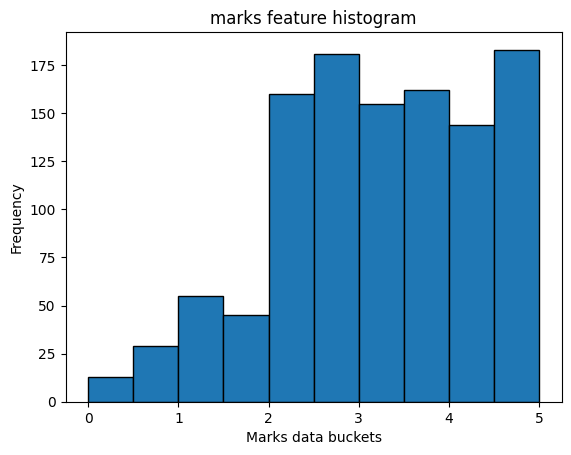

In [7]:
'''
A2. Take any feature from your dataset. 
Observe the density pattern for that feature by plotting the
histogram. Use buckets (data in ranges) for histogram generation and study. Calculate the mean and
variance from the available data.
(Suggestion: numpy.histogram()gives the histogram data. 
Plot of histogram may be achieved with matplotlib.pyplot.hist())
'''
feature = numeric_dtrain['output']
counts, bin_edges = np.histogram(feature, bins=10)
mp.hist(feature, bins=10, edgecolor='k')
mp.xlabel('Marks data buckets')
mp.ylabel('Frequency')
mp.title('marks feature histogram')
mp.show()
#Density pattern:
#it shows that most people scored between 2.5 to 3 and between 4.5 to 5
#there is narrow distribution between the buckets so the spread is less


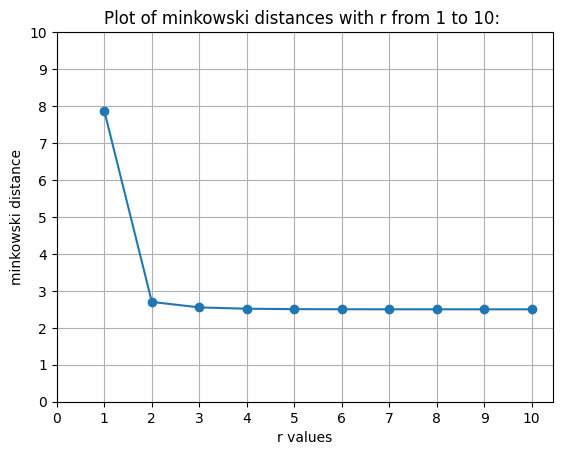

In [8]:
'''
A3. Take any two feature vectors from your dataset. 
Calculate the Minkowski distance with r from 1 to 10. 
Make a plot of the distance and observe the nature of this graph.

'''
#choosing 360th and 1120th vectors.
feature_vector_1 = numeric_dtrain.iloc[359].values
feature_vector_2 = numeric_dtrain.iloc[1119].values

r = [1,2,3,4,5,6,7,8,9,10]
mink_dists = []
for i in range(1,11):
    d = np.linalg.norm(feature_vector_1 - feature_vector_2, ord=i)
    mink_dists.append(d)

mp.plot(r, mink_dists,marker='o')
mp.xticks([0,1,2,3,4,5,6,7,8,9,10])
mp.yticks([0,1,2,3,4,5,6,7,8,9,10])
mp.xlabel('r values')
mp.ylabel('minkowski distance')
mp.title('Plot of minkowski distances with r from 1 to 10: ')
mp.grid(True)
mp.show()

In [9]:
'''
A4. Divide dataset in your project into two parts - train & test set. 
To accomplish this, use the train_test_split() function available in SciKit. 
See below sample code for help:
>>> import numpy as np
>>> from sklearn.model_selection import train_test_split
>>> X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)
X is the feature vector set for your project and y is the class levels for vectors present in X.
Note: Before set split, make sure you have only two classes. 
If your project deals with multi-class problem, take any two classes from them.
'''
#choosing 2 classes. class 0-incorrect and class 2-correct. removing class 1-partially correct
class1_removed_set = numeric_dtrain[numeric_dtrain['class_encoded'].isin([0 , 2])]
X = class1_removed_set.iloc[0:, 0:-2]
Y = class1_removed_set['class_encoded']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
Y_test = pd.DataFrame(Y_test)
class1_removed_set.to_excel('class0and2_data.xlsx', index=False)
X_test.to_excel('X_test_data.xlsx', index=False)
Y_test.to_excel('Y_test_data.xlsx', index=False)


In [10]:
'''
A5. Train a kNN classifier (k = 3) using the training set obtained from above exercise. 
Following code for help:
>>> import numpy as np
>>> from sklearn.neighbors import KNeighborsClassifier
>>> neigh = KNeighborsClassifier(n_neighbors=3)
>>> neigh.fit(X, y)

'''
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, Y_train)


KNeighborsClassifier(n_neighbors=3)

In [11]:
'''
A6. Test the accuracy of the kNN using the test set obtained from above exercise. 
Following code for help.
>>> neigh.score(X_test, y_test)

'''
accuracy = neigh.score(X_test, Y_test)
print("kNN classifier ( with k=3) :\nAccuracy of the kNN =", accuracy)


kNN classifier ( with k=3) :
Accuracy of the kNN = 0.8571428571428571


In [12]:
'''
A7. Use the predict() function to study the prediction behavior of the classifier for test vectors.
>>> neigh.predict(X_test)
Perform classification for a given vector using neigh.predict(<<test_vect>>). 
This shall produce the class of the test vector (test_vect is any feature vector from your test set).

'''
arr= X_test.iloc[34]
predicted_class = neigh.predict([arr])

print("Predicted Class:", predicted_class)

Predicted Class: [0]


C:\Users\subhi\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


NN classifier ( with k=1) :
Accuracy of the kNN = 0.873015873015873


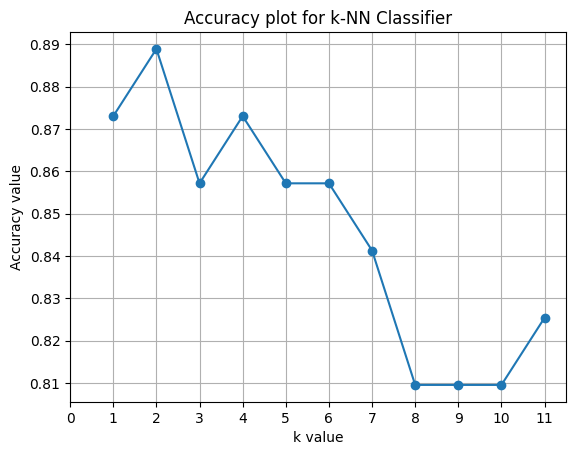

In [13]:
'''
A8. Make k = 1 to implement NN classifier and compare the results with kNN (k = 3). 
Vary k from 1 to 11 and make an accuracy plot.

'''
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(X_train, Y_train)
Ps = neigh1.predict(X_test)    
accuracy1 = accuracy_score(Y_test, Ps)
print("NN classifier ( with k=1) :\nAccuracy of the kNN =", accuracy1)

new_accuracy_vals = []
for k in range(1, 12):
    neigh2 = KNeighborsClassifier(n_neighbors=k)
    neigh2.fit(X_train, Y_train)
    predictions = neigh2.predict(X_test)    
    accuracy_k = accuracy_score(Y_test, predictions)
    new_accuracy_vals.append(accuracy_k)

mp.plot([1,2,3,4,5,6,7,8,9,10,11], new_accuracy_vals, marker='o')
mp.title('Accuracy plot for k-NN Classifier')
mp.xlabel('k value')
mp.ylabel('Accuracy value')
mp.grid(True)
mp.xticks(range(0, 12))
mp.show()


In [14]:
'''
A9. Please evaluate confusion matrix for your classification problem. 
From confusion matrix, the other performance metrics such as precision, recall and F1-Score measures for both training and test data. 
Based on your observations, infer the models learning outcome (underfit / regularfit / overfit).
'''

neigh3 = KNeighborsClassifier(n_neighbors=5)
neigh3.fit(X_train, Y_train)
train_predictions = neigh3.predict(X_train)
test_predictions = neigh3.predict(X_test)

train_confusion_matrix = confusion_matrix(Y_train, train_predictions)
test_confusion_matrix = confusion_matrix(Y_test, test_predictions)

train_classification_report = classification_report(Y_train, train_predictions)
test_classification_report = classification_report(Y_test, test_predictions)

print("Confusion Matrix for Training Data :\n", train_confusion_matrix)
print("Confusion Matrix for Testing Data :\n", test_confusion_matrix)
print("\nClassification Report for Training Data):\n", train_classification_report)
print("\nClassification Report for Testing Data):\n", test_classification_report)
print("Since this model has same performance and it gives good results on both training and test data, it is a regular fit.")

Confusion Matrix for Training Data :
 [[88 12]
 [ 2 44]]
Confusion Matrix for Testing Data :
 [[36  6]
 [ 3 18]]

Classification Report for Training Data):
               precision    recall  f1-score   support

           0       0.98      0.88      0.93       100
           2       0.79      0.96      0.86        46

    accuracy                           0.90       146
   macro avg       0.88      0.92      0.89       146
weighted avg       0.92      0.90      0.91       146


Classification Report for Testing Data):
               precision    recall  f1-score   support

           0       0.92      0.86      0.89        42
           2       0.75      0.86      0.80        21

    accuracy                           0.86        63
   macro avg       0.84      0.86      0.84        63
weighted avg       0.87      0.86      0.86        63

Since this model has same performance and it gives good results on both training and test data, it is a regular fit.
